In [31]:
%load_ext autoreload
%autoreload 2

import os
import time
import sys

import numpy as np
import matplotlib.pyplot as plt

from data_augmentation import *
from data_loading import *
from plotting import *
from training import *
from weibull import *
from wtte import *

# Work around an issue on macOS with multiple versions 
# of OpenMP loading and killing the kernel.
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
model_type = "wtte-naive"

clip_length = 30
cutoff = 30000
drop_censored = True
drop_criteria_column = "timeToUnjamUncensored"
features = ["ratioReference"]
jam_ratio = 0.47
min_jam_length = 5
min_non_jam_length = 5
memory_length = 10
normalize_x = True
use_log=False
y_train_variable="timeToUnjamClipped"

model_name = f"{model_type}_{clip_length}_{cutoff}_{drop_censored}_{drop_criteria_column}_{'-'.join(features)}_{str(jam_ratio).replace('.', '')}_{min_jam_length}_{min_non_jam_length}_{memory_length}_{normalize_x}_{use_log}_{y_train_variable}"

print(model_name)

wtte-naive_30_30000_True_timeToUnjamUncensored_ratioReference_047_5_5_10_True_False_timeToUnjamClipped


Loading data.
Loading took 86.11 seconds
Data frame has shape (22558642, 9)
NaNs before:
measurementSiteReference           0
periodStart                        0
dataError                          0
avgVehicleSpeed             22558642
avgTravelTime                5721179
lengthAffected                     0
referenceAvgVehicleSpeed    22558642
referenceAvgTravelTime        493864
timeOfDay                          0
dtype: int64

NaNs after:
measurementSiteReference    0
periodStart                 0
dataError                   0
avgVehicleSpeed             0
avgTravelTime               0
lengthAffected              0
referenceAvgVehicleSpeed    0
referenceAvgTravelTime      0
timeOfDay                   0
ratioReference              0
dtype: int64
Dropping columns: ['referenceAvgVehicleSpeed', 'avgTravelTime', 'referenceAvgTravelTime', 'lengthAffected']


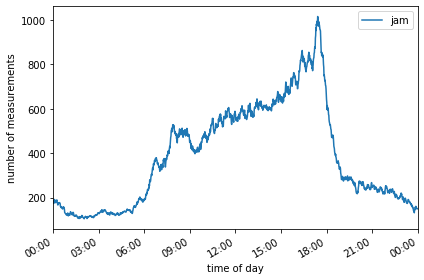

Number of jams (1 = jam)
0    22001348
1      557294
Name: isJam, dtype: int64
Calculating jam lengths.
Dropping columns: ['isNotJam', 'cumulativeLocalJamLength', 'cumulativeLocalNonJamLength']
Most common non-jam length: 1 minutes


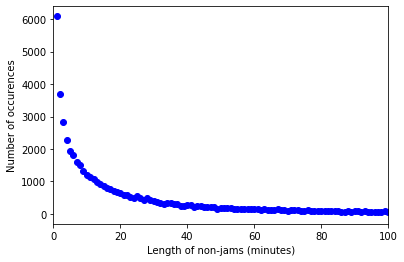

Most common jam length: 1 minutes


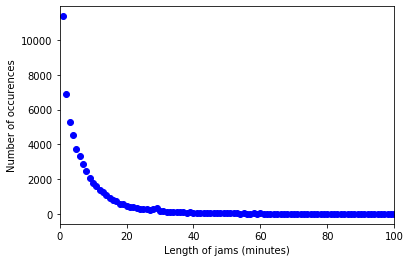

Number of jams before merging:
0    22001348
1      557294
Name: isJam, dtype: int64
Merging close jams.
Number of jams after merging:
0    21970266
1      588376
Name: isJamCleaned, dtype: int64
Recalculating jam lengths.
Dropping columns: ['isNotJam', 'cumulativeLocalJamLength', 'cumulativeLocalNonJamLength']
Most common non-jam length: 5 minutes


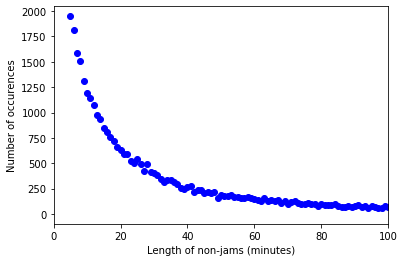

Most common jam length: 1 minutes


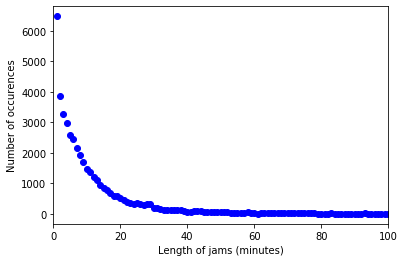

Number of jams before discarding:
0    21970266
1      588376
Name: isJamCleaned, dtype: int64
Discarding short jams.
Number of jams after discarding:
0    22006170
1      552472
Name: isJamCleaned, dtype: int64
Dropping columns: ['maxLocalJamLength', 'maxLocalNonJamLength']
Calculating time-to-events.
Dropping columns: ['isNotJam']


In [52]:
df = load_and_augment_data(get_path(),
                           min_non_jam_length=min_non_jam_length,
                           min_jam_length=min_jam_length,
                           jam_ratio=jam_ratio,
                           show_final_statistics=False)

Distribution of time-to-event for jams.


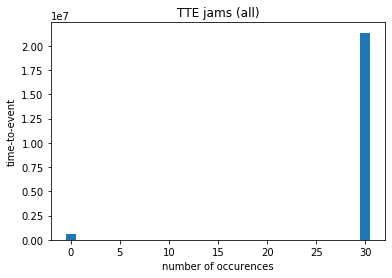

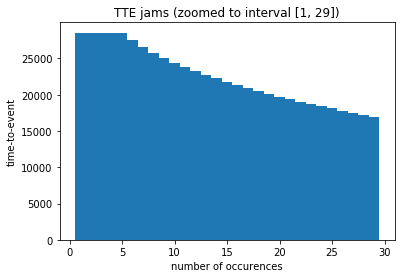

Distribution of time-to-event for unjams.


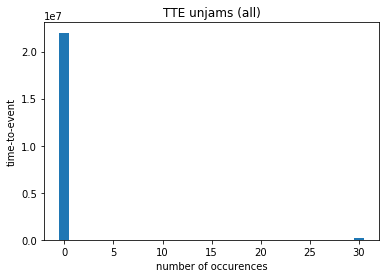

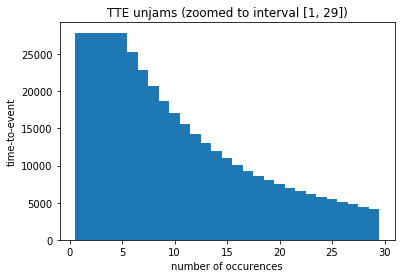

In [53]:
df = clip_tte(df, clip_length=clip_length, use_log=use_log, show_plots=True)

In [55]:
(x_train, y_train, 
 x_val, y_val, 
 x_test, y_test) = generate_training_data(df, drop_censored=drop_censored,
                                          drop_criteria_column=drop_criteria_column,
                                          cutoff=cutoff,
                                          show_plots=False,
                                          y_train_variable=y_train_variable,
                                          features=features,
                                          normalize=normalize_x)

x_train: (590, 30000, 1), y_train: (590, 30000, 1)
x_val: (46, 30000, 1), y_val: (46, 30000, 1)
x_test: (46, 30000, 1), y_test: (46, 30000, 1)


In [56]:
_, y_train_segmented = segment_timeseries(x_train, y_train, length=memory_length)
x_test_segmented, y_test_segmented = segment_timeseries(x_test, y_test, length=memory_length)

x shape: (590, 29990, 10, 1), y shape: (590, 29990, 1)
x shape: (46, 29990, 10, 1), y shape: (46, 29990, 1)


In [57]:
init_alpha = -1.0/np.log(1.0-1.0/(np.nanmean(y_train_segmented)+1.0))
print("init_alpha:", init_alpha)

beta = 1

init_alpha: 0.8090533227936358


In [58]:
class NaiveModel:
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta
    
    def predict(self, x):
        return np.repeat(weibull_quantile(self.alpha, self.beta, 0.6), len(x)).reshape(-1, 1)
    
model = NaiveModel(init_alpha, beta)

Test road 0/46
MSE: 3.137111270698095
MAE: 0.9013236456445538
CE: 0.6817924516767974


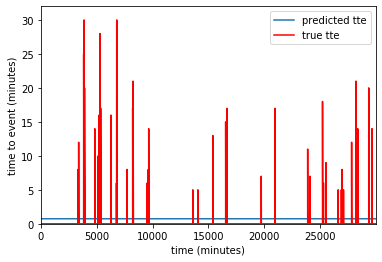

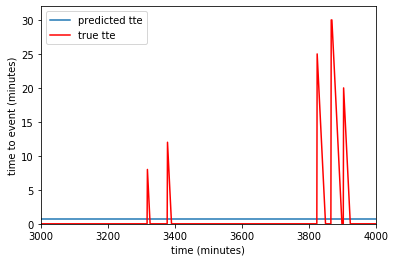

Test road 1/46
MSE: 8.168880687751436
MAE: 1.201896977363844
CE: 2.089141059698833


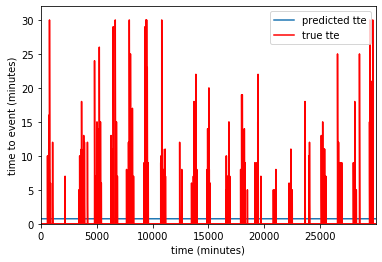

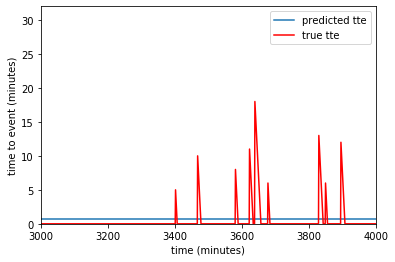

Test road 2/46
MSE: 0.5506596638182687
MAE: 0.7415810362390318
CE: 0.005758382193217184


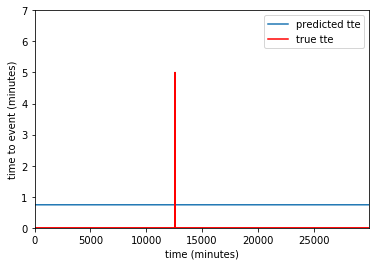

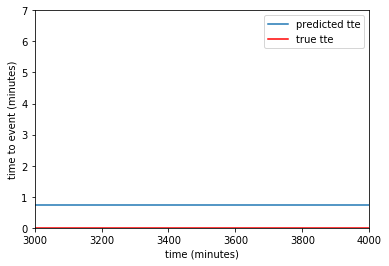

Test road 3/46
MSE: 0.5495672944230715
MAE: 0.7413280612677974
CE: 9.992007221626413e-16


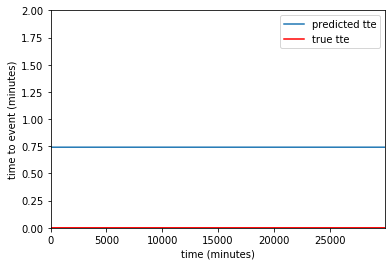

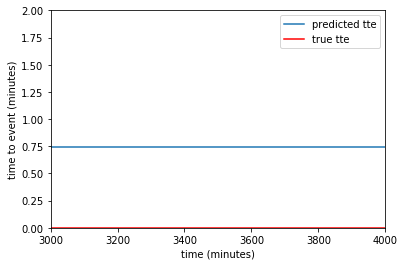

Test road 4/46
MSE: 1.0219233574598376
MAE: 0.7830657925856984
CE: 0.27985737459030763


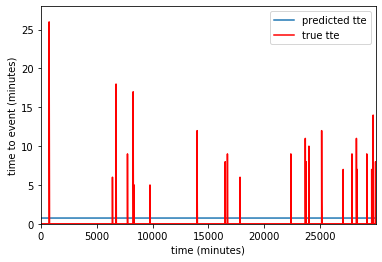

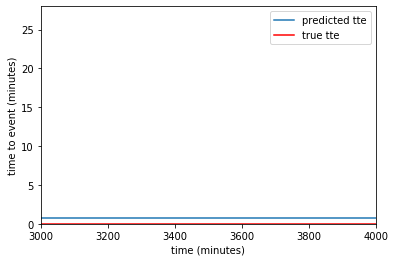

Test road 5/46
MSE: 0.5631766540733767
MAE: 0.7429849729934429
CE: 0.012668440825076607


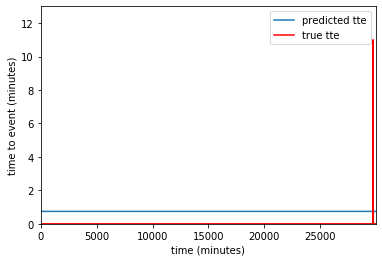

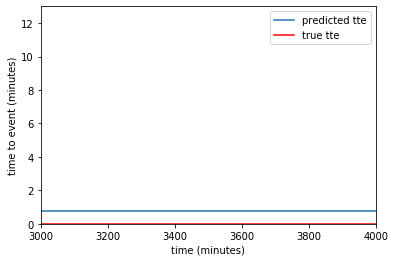

Test road 6/46
MSE: 0.6756269881631854
MAE: 0.7531081028460691
CE: 0.08522405645960054


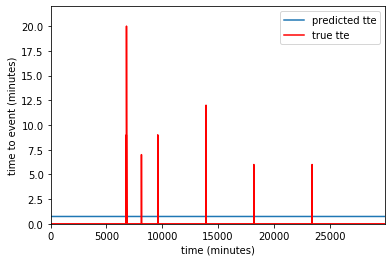

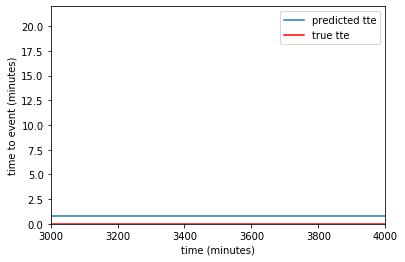

Test road 7/46
MSE: 2.9757761560629596
MAE: 0.9344180595293164
CE: 1.2795125233326372


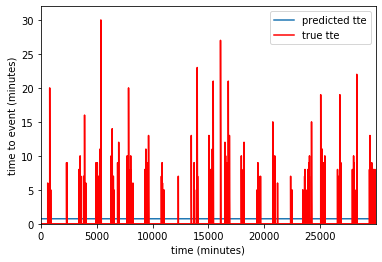

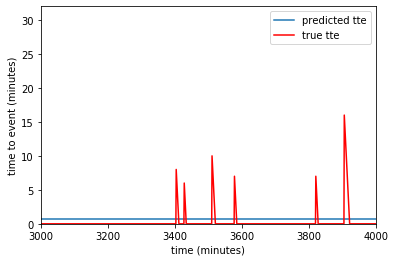

Test road 8/46
MSE: 0.6303262256986573
MAE: 0.7487881627300682
CE: 0.04837041042301696


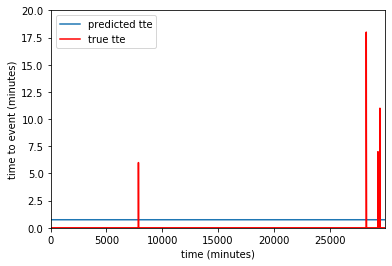

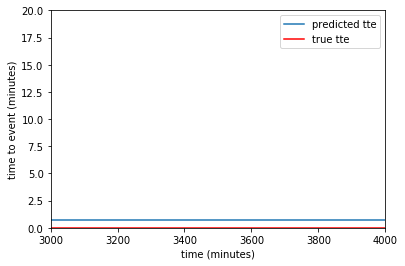

Test road 9/46
MSE: 7.955759108264743
MAE: 1.040873432852685
CE: 0.621905276867349


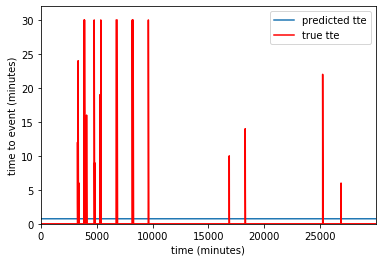

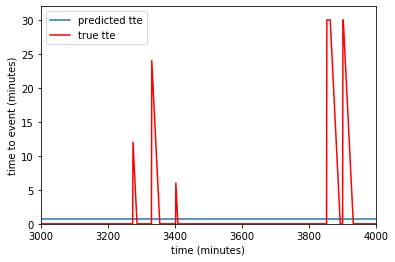

Test road 10/46
MSE: 0.5495672944230715
MAE: 0.7413280612677974
CE: 9.992007221626413e-16


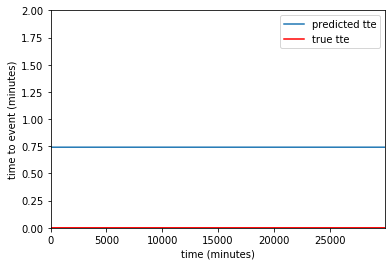

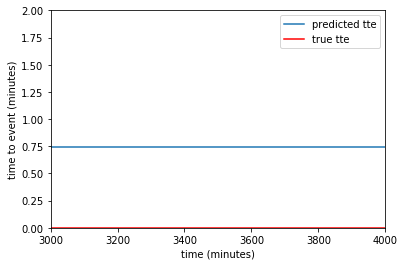

Test road 11/46
MSE: 0.5869045170001252
MAE: 0.7459814458652919
CE: 0.03685364603658459


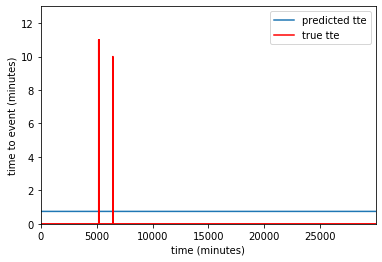

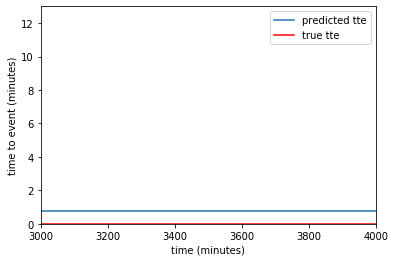

Test road 12/46
MSE: 1.460347529939209
MAE: 0.7875335521793672
CE: 0.14626290770769212


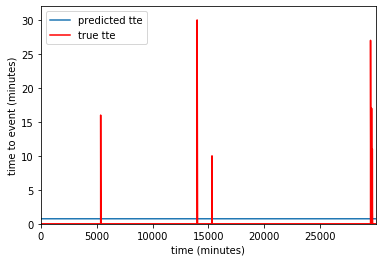

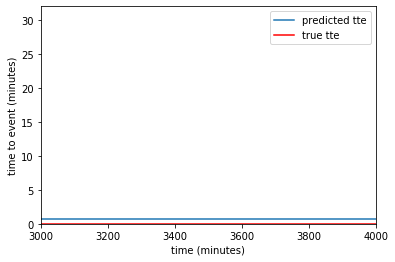

Test road 13/46
MSE: 0.597110330536515
MAE: 0.746785182553014
CE: 0.04376370466844401


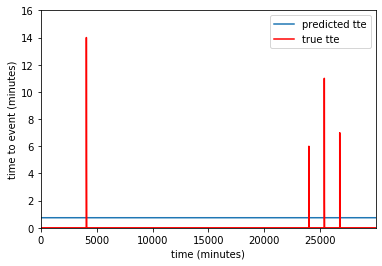

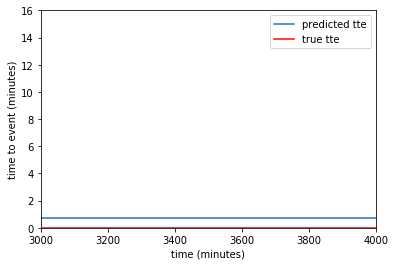

Test road 14/46
MSE: 0.8721421459697262
MAE: 0.7657549018470503
CE: 0.10365087947789234


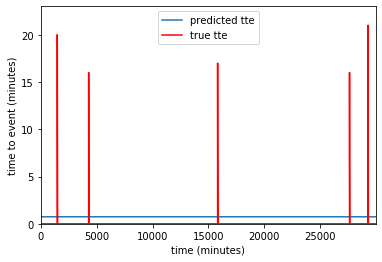

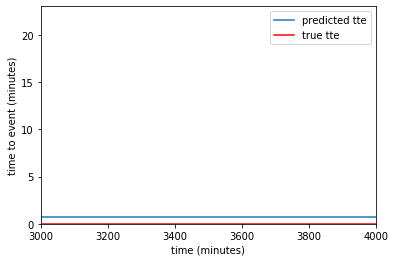

Test road 15/46
MSE: 0.5495672944230715
MAE: 0.7413280612677974
CE: 9.992007221626413e-16


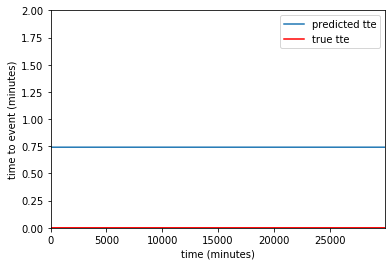

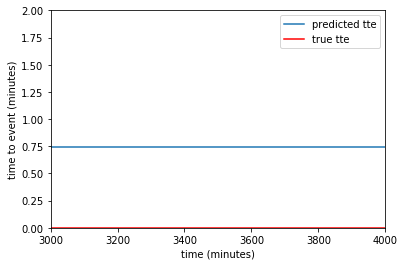

Test road 16/46
MSE: 0.5545897812383006
MAE: 0.7421329545995652
CE: 0.009213411509146898


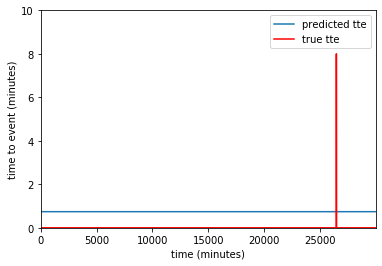

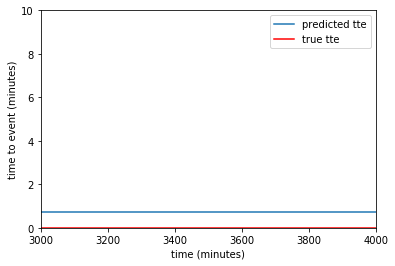

Test road 17/46
MSE: 0.5495672944230715
MAE: 0.7413280612677974
CE: 9.992007221626413e-16


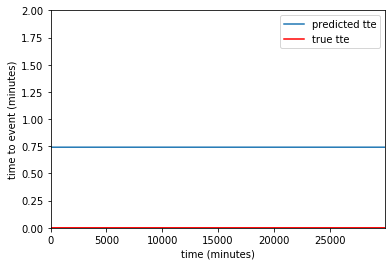

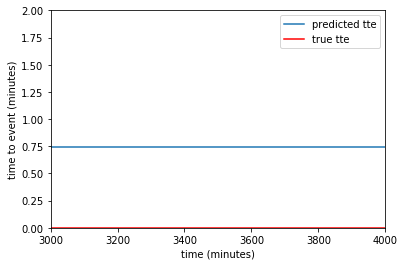

Test road 18/46
MSE: 2.0414933422825627
MAE: 0.8107414863205121
CE: 0.21306014114899985


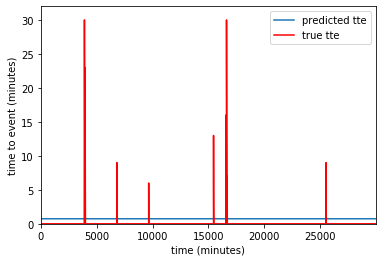

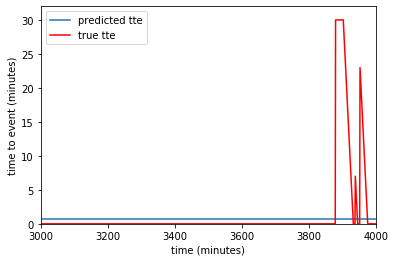

Test road 19/46
MSE: 0.5495672944230715
MAE: 0.7413280612677974
CE: 9.992007221626413e-16


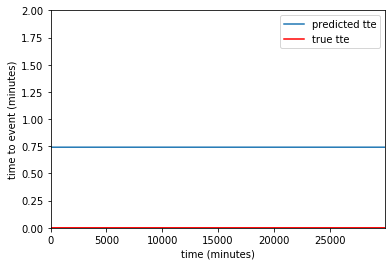

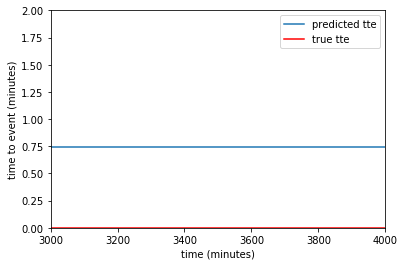

Test road 20/46
MSE: 0.6609781674000214
MAE: 0.7516615684911435
CE: 0.05988717480944932


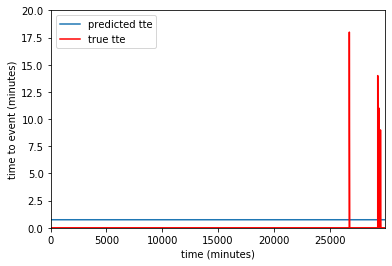

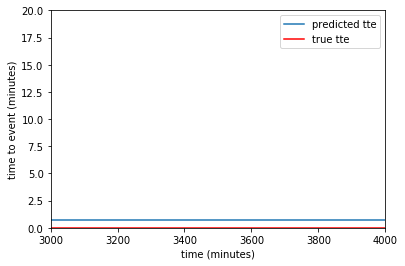

Test road 21/46
MSE: 0.5495672944230715
MAE: 0.7413280612677974
CE: 9.992007221626413e-16


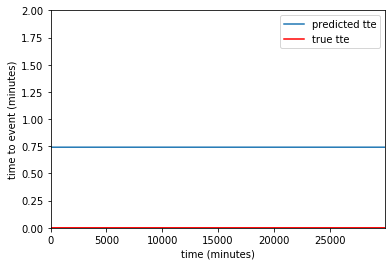

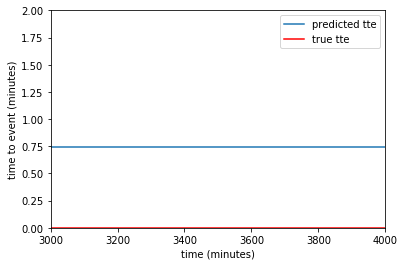

Test road 22/46
MSE: 9.118917688603336
MAE: 1.0874376161855785
CE: 0.7520447144340349


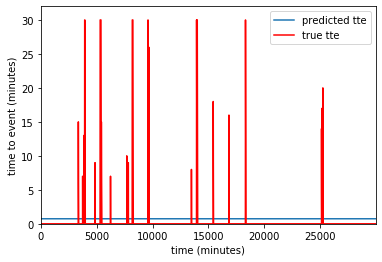

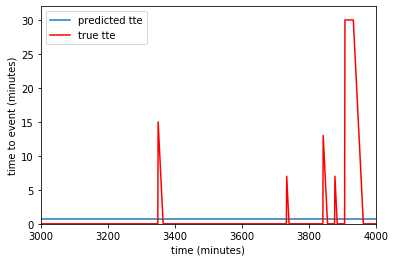

Test road 23/46
MSE: 34.234596346702375
MAE: 2.366789765428376
CE: 5.152600386489845


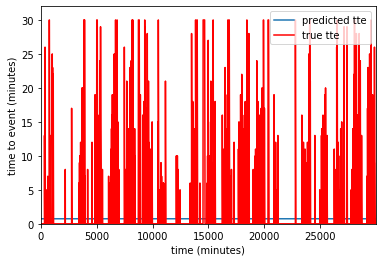

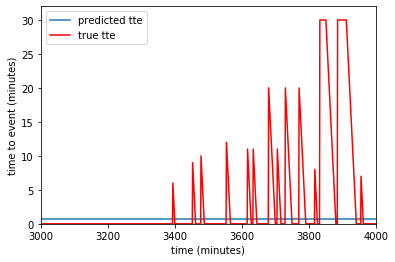

Test road 24/46
MSE: 1.4813664951721255
MAE: 0.7905358082714445
CE: 0.18196487730563246


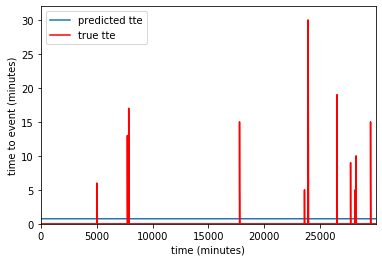

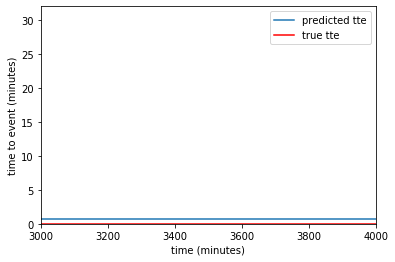

Test road 25/46
MSE: 7.140391318668713
MAE: 0.9694648267874741
CE: 0.3201660499428209


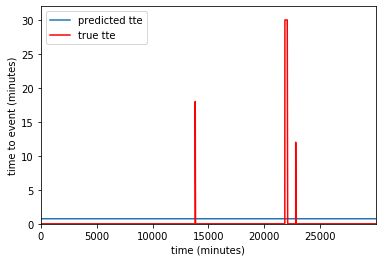

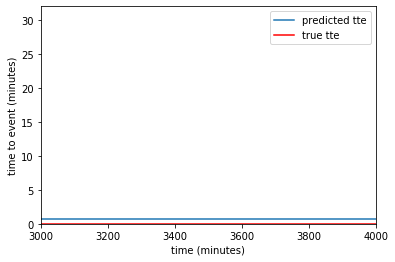

Test road 26/46
MSE: 0.6348838070695377
MAE: 0.7473416283751427
CE: 0.02303352877286574


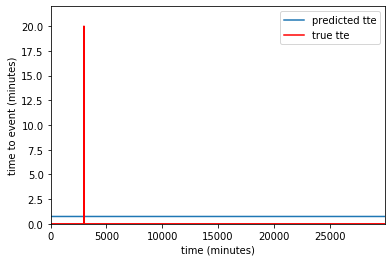

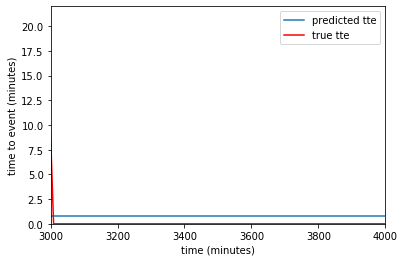

Test road 27/46
MSE: 0.5495672944230715
MAE: 0.7413280612677974
CE: 9.992007221626413e-16


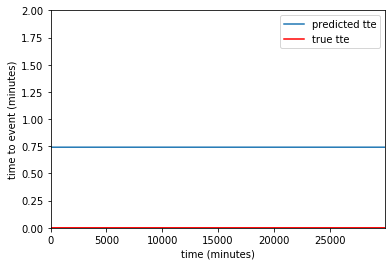

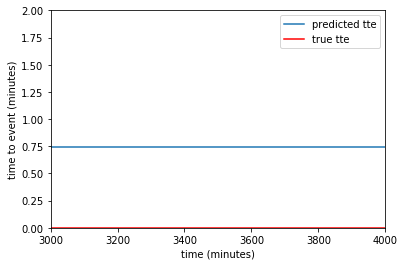

Test road 28/46
MSE: 0.9018365827872972
MAE: 0.7771947573087286
CE: 0.2418520521150808


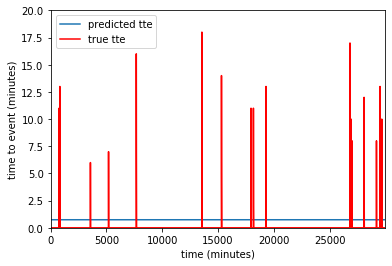

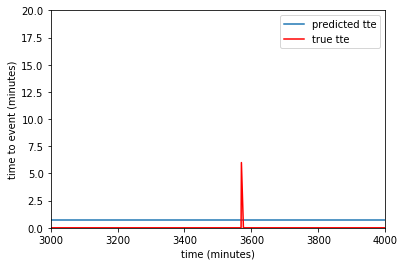

Test road 29/46
MSE: 0.9570325834964605
MAE: 0.7668012037095963
CE: 0.09558914440738969


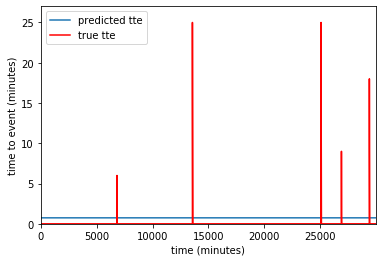

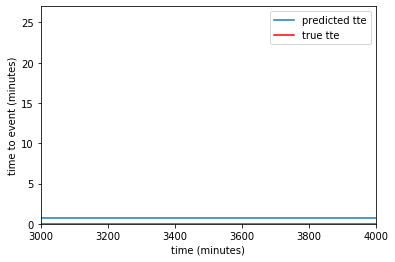

Test road 30/46
MSE: 0.5673849944044728
MAE: 0.7433356680210342
CE: 0.013820117263719841


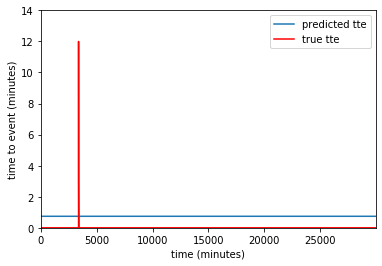

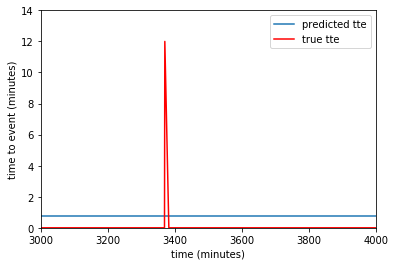

Test road 31/46
MSE: 0.6953692147557116
MAE: 0.7537358641406791
CE: 0.07370729207316819


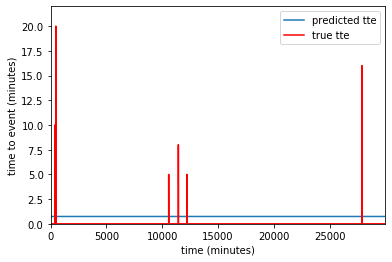

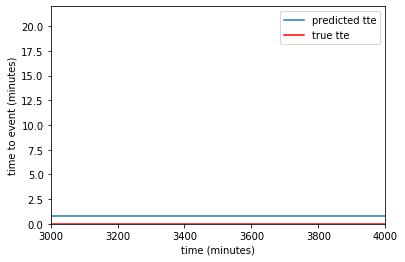

Test road 32/46
MSE: 3.006456356480706
MAE: 0.8512702254237802
CE: 0.30980096199503177


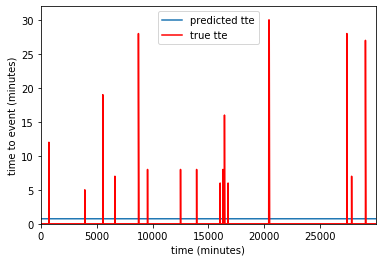

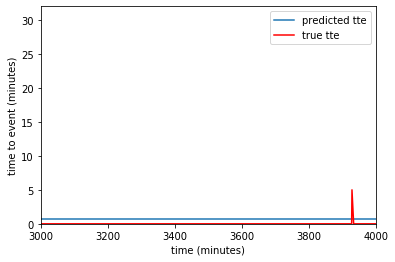

Test road 33/46
MSE: 0.5506596638182688
MAE: 0.7415810362390319
CE: 0.005758382193217185


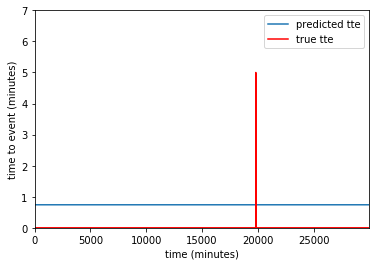

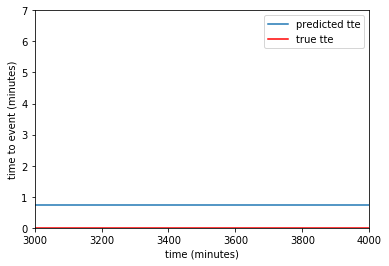

Test road 34/46
MSE: 1.2167427068325296
MAE: 0.8027981049547493
CE: 0.43072698805257165


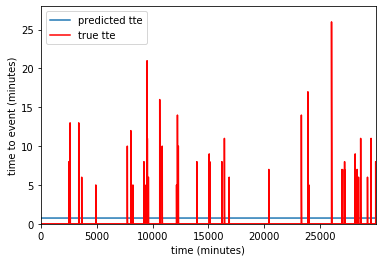

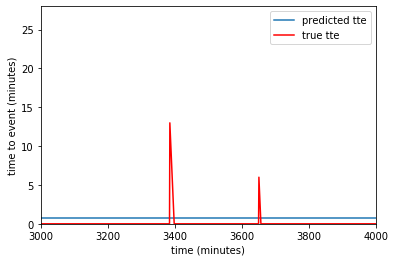

Test road 35/46
MSE: 0.6646939419442606
MAE: 0.7489295379163984
CE: 0.031095263843368404


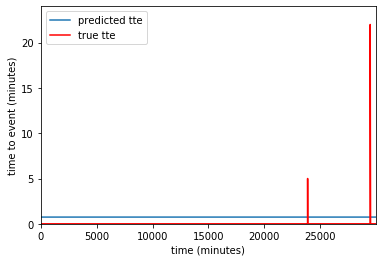

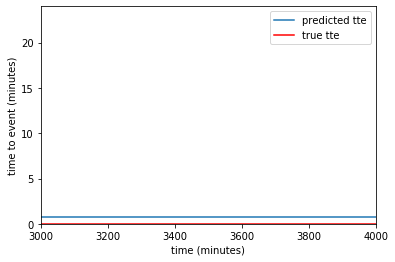

Test road 36/46
MSE: 39.39927037736792
MAE: 2.089309332707365
CE: 1.856502419092899


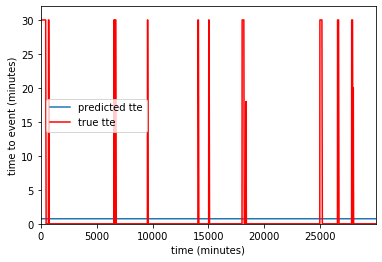

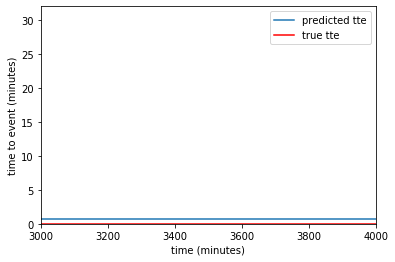

Test road 37/46
MSE: 1.260053476817267
MAE: 0.8005651835727864
CE: 0.4330303409298581


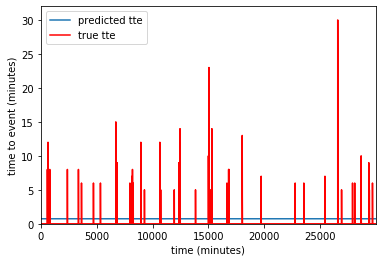

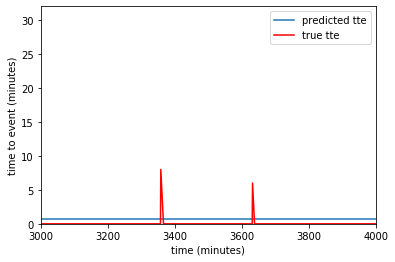

Test road 38/46
MSE: 0.5495672944230715
MAE: 0.7413280612677974
CE: 9.992007221626413e-16


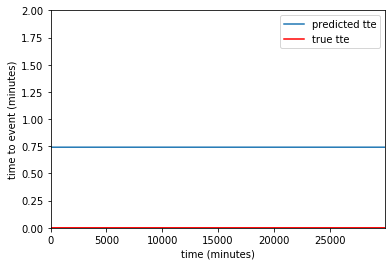

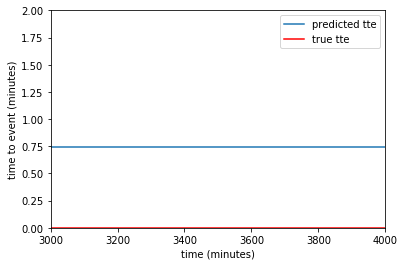

Test road 39/46
MSE: 53.06615443397507
MAE: 3.5070774887728637
CE: 10.048376927162247


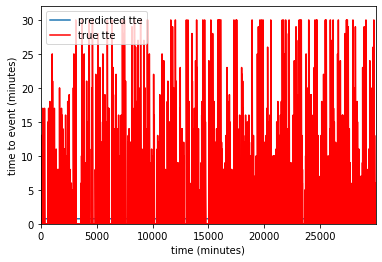

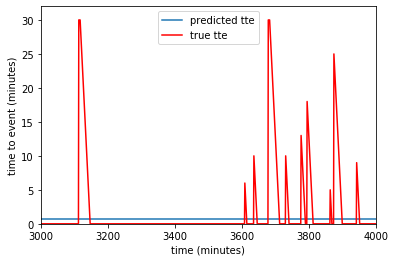

Test road 40/46
MSE: 0.8564075983318773
MAE: 0.7615545589096866
CE: 0.07255561563452494


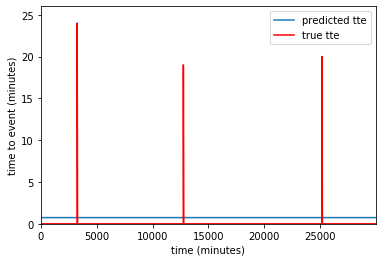

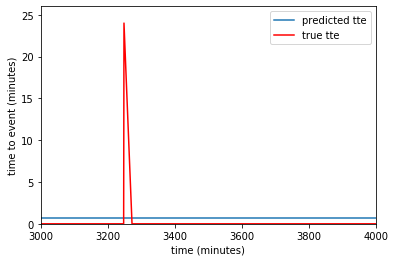

Test road 41/46
MSE: 0.5495672944230715
MAE: 0.7413280612677974
CE: 9.992007221626413e-16


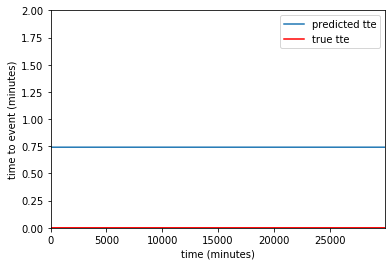

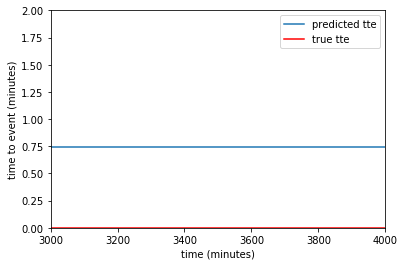

Test road 42/46
MSE: 11.52292652328047
MAE: 1.1244976406500267
CE: 0.5481979847941818


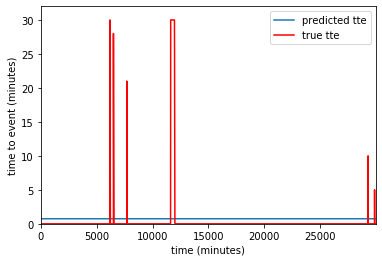

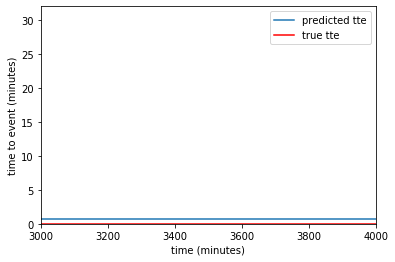

Test road 43/46
MSE: 36.3228423233871
MAE: 2.0995689792883763
CE: 2.5993337220177866


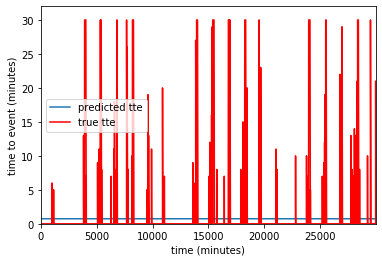

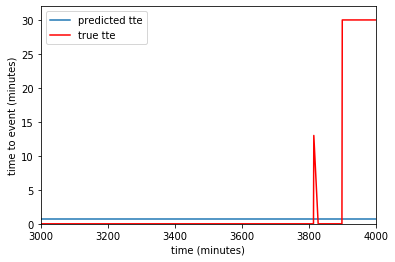

Test road 44/46
MSE: 0.7253081008468494
MAE: 0.7550570180967394
CE: 0.08176902714367082


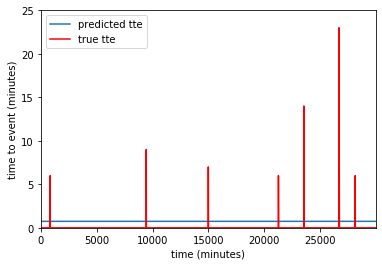

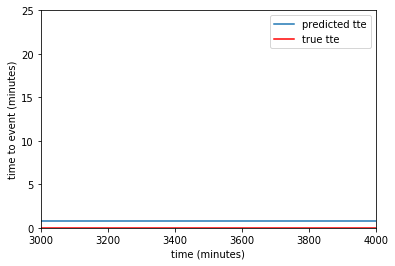

Test road 45/46
MSE: 0.5495672944230715
MAE: 0.7413280612677974
CE: 9.992007221626413e-16


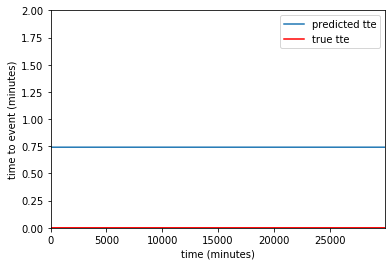

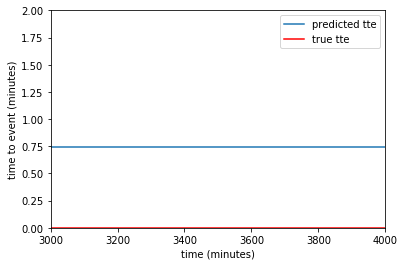

MSE (whole test set): 5.266777682724568
MAE (whole test set): 0.9542773506973586
CE (whole test set): 0.6301923399367166


(5.266777682724568, 0.9542773506973586, 0.6301923399367166)

In [59]:
get_mean_error(model=model, x_test=x_test_segmented, y_test=y_test_segmented, memory_length=memory_length, reverse_log=use_log, len_features=len(features), model_type=model_type)